In [1]:
import os
import sys
import time
import random
import pandas as pd
from pathlib import Path
import numpy as np
from tensorly.decomposition import tucker

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

from side_info_decoding.utils import set_seed, load_data_from_pids, sliding_window_over_trials

seed = 666
set_seed(seed)

In [2]:
%matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 10
BIGGER_SIZE = 15
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=2)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 10

In [3]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    # "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    # "523f8301-4f56-4faf-ab33-a9ff11331118",
    # "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    # '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
    # '143dd7cf-6a47-47a1-906d-927ad7fe9117',
    # '16799c7a-e395-435d-a4c4-a678007e1550',
    # '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
    # '1e176f17-d00f-49bb-87ff-26d237b525f1',
    # '31f3e083-a324-4b88-b0a4-7788ec37b191'
]

In [4]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="po",
    behavior="choice",
    data_type="good_ks",
    n_t_bins = 30,
    align_time_type="stimOn_times",
    t_before=0.5,
    t_after=1.0,
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 367 (active: 367)
prior for this session is not found.
found 367 trials from 17.56 to 2310.24 sec.
found 24 good units in region po


Compute spike count: 100%|██████████████████| 367/367 [00:00<00:00, 2894.29it/s]


In [6]:
pid = pids[0]
R = 2 
d = 0 
X, Y = X_dict[pid], Y_dict[pid]
K, C, T = X.shape
X = X.transpose(0,-1,1)

In [7]:
# preprocess data

n_R = sum(Y == 1)
n_L = sum(Y == 0)
Y_one_hot = np.zeros((len(Y), 2))
Y_one_hot[Y == 1, 1] = 1
Y_one_hot[Y == 0, 0] = 1
# Y_one_hot.T[0] /= np.sqrt(n_L)
# Y_one_hot.T[1] /= np.sqrt(n_R)
Y_one_hot.T[0] -= Y_one_hot.T[0].mean()
Y_one_hot.T[1] -= Y_one_hot.T[1].mean()

Y_c = (Y - Y.mean()).reshape(-1,1)
X_c = X - X.mean()

### closed-form reduced-rank

In [23]:
def reduced_rank_close_form(X_c, Y_c):
    
    # compute U
    S_b = np.einsum("ndk,ktc->ndtc", (X_c.T @ (Y_c @ Y_c.T)), X_c)
    S_t = np.einsum("ktc,kdn->ctdn", X_c, X_c)
    inv_S_t = np.linalg.pinv(S_t)
    inv_S_t_S_b = np.einsum("ctnd,ndab->ctab", inv_S_t, S_b)
    core, factors = tucker(inv_S_t_S_b, rank=[R, T, T, R])
    
    fig, axes = plt.subplots(1, 4, figsize=(12,2))
    for i in range(len(factors)):
        axes[i].imshow(factors[i].T, aspect="auto", cmap="coolwarm")
    plt.tight_layout()
    plt.show()
    
    U = factors[-1]
    
    # compute V
    G_part = np.einsum("cr, ctdn->rtdn", U, S_t)
    G = np.einsum("rtdn, ns->rs", G_part, U)
    H = U.T @ (X_c.T @ Y_c).squeeze()
    V = np.linalg.inv(G) @ H
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,2))
    ax1.imshow(V, aspect="auto", cmap="coolwarm")
    ax2.plot(V.T)
    plt.tight_layout()
    plt.show()
    
    return U, V

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X_c, Y_c, test_size=0.2, random_state=seed)

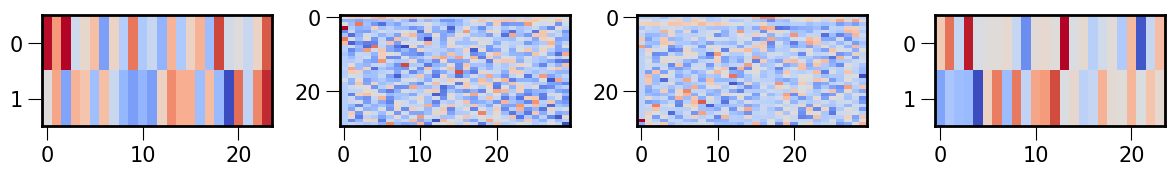

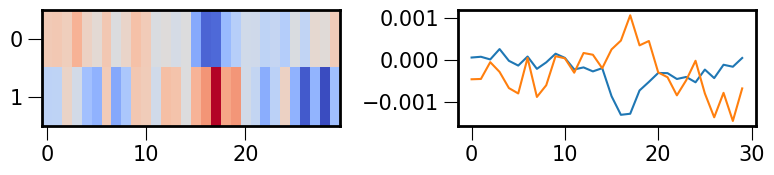

In [25]:
U, V = reduced_rank_close_form(X_train, Y_train)

In [26]:
_, _, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [27]:
Yhat = np.einsum("ktr,rt->k", X_test @ U, V)
roc_auc_score(Y_test, Yhat)

0.7762017336485421

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [29]:
clf = LogisticRegression().fit(X_train.reshape((-1,T*C)), Y_train)
yhat = clf.predict(X_test.reshape((-1,T*C)))
roc_auc_score(Y_test, yhat)

0.6371158392434988

#### cross-validation

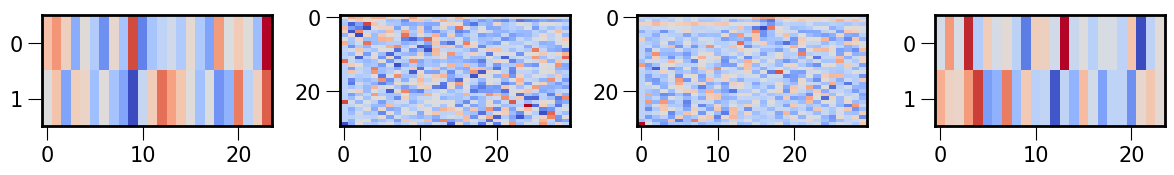

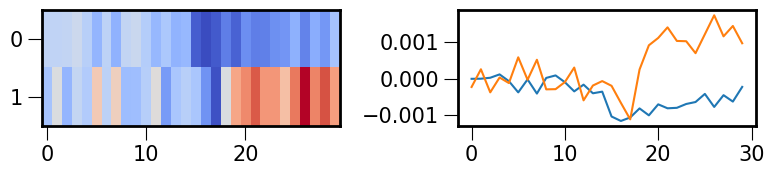

reduced-rank:  0.7911338448422848
baseline:  0.6389599317988065


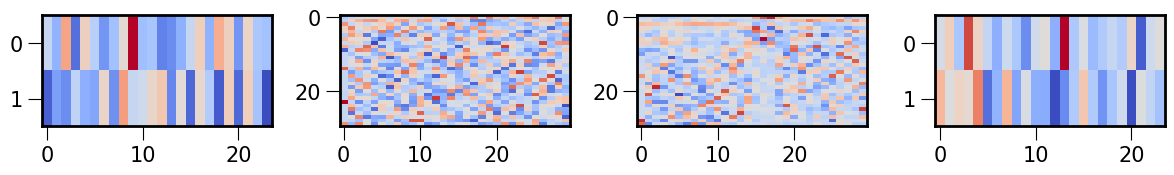

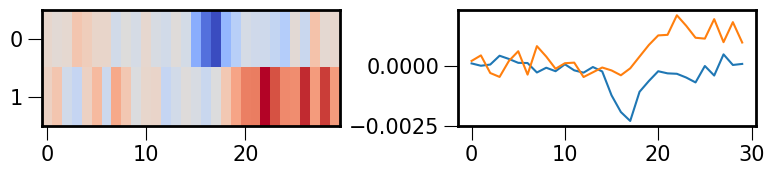

reduced-rank:  0.7297527706734868
baseline:  0.5541346973572038


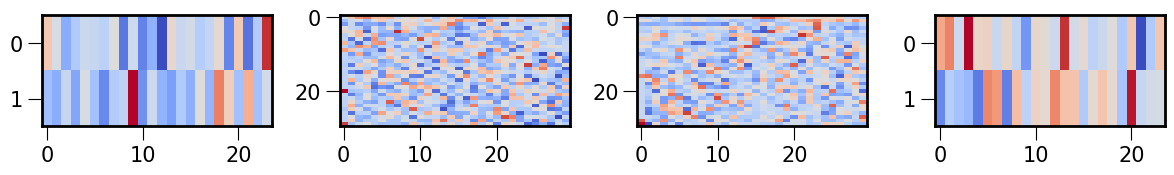

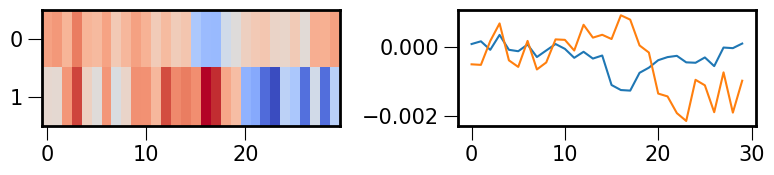

reduced-rank:  0.7566844919786097
baseline:  0.6457219251336899


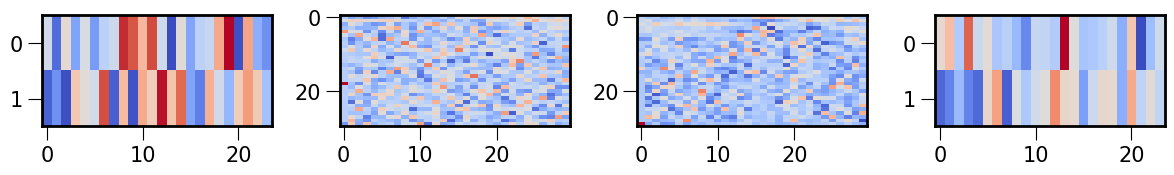

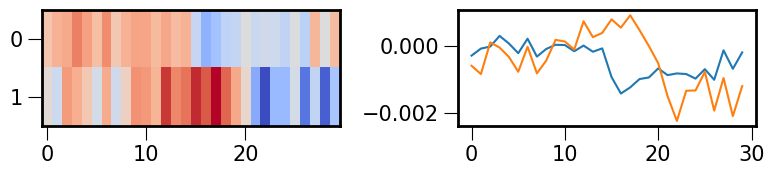

reduced-rank:  0.6648841354723708
baseline:  0.6292335115864528


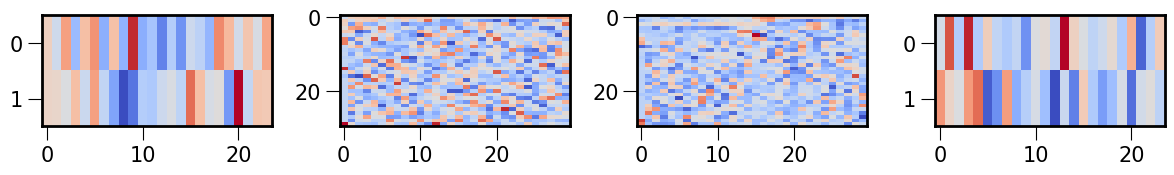

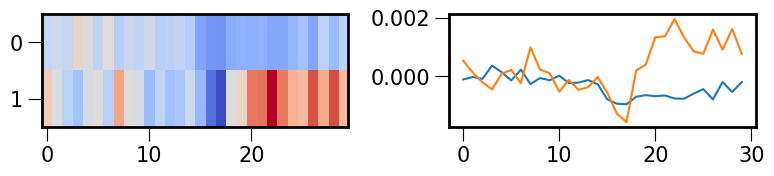

reduced-rank:  0.7730434782608695
baseline:  0.5821739130434782


In [30]:
n_folds = 5

baseline_aucs, rrr_aucs = [], []
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
for train, test in skf.split(X, Y):
    X_train, X_test, Y_train, Y_test = X_c[train], X_c[test], Y_c[train], Y_c[test]
    U, V = reduced_rank_close_form(X_train, Y_train)
    Y_train, Y_test = Y[train], Y[test]
    Yhat = np.einsum("ktr,rt->k", X_test @ U, V)
    auc = roc_auc_score(Y_test, Yhat)
    print("reduced-rank: ", auc)
    rrr_aucs.append(auc)
    X_train, X_test, Y_train, Y_test = X[train], X[test], Y[train], Y[test]
    clf = LogisticRegression().fit(X_train.reshape((-1,T*C)), Y_train)
    yhat = clf.predict(X_test.reshape((-1,T*C)))
    auc = roc_auc_score(Y_test, yhat)
    baseline_aucs.append(auc)
    print("baseline: ", auc)

In [31]:
print(np.mean(baseline_aucs))
print(np.mean(rrr_aucs))

0.6100447957839262
0.7430997442455244


### closed-form multi-task reduced-rank